## Is it a drunk person?

## Objective: create a model that recognize a drunk person, using mainly the FastAI library.


In [4]:
!pip install -Uqq fastai duckduckgo_search

## Step 1: Download images of drunk person and non-drunk person

In [5]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [7]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('drunk person', max_images=1)
urls[0]

Searching for 'drunk person'


'https://merriam-webster.com/assets/mw/images/gallery/gal-wap-slideshow-slide/words-for-drunk-people-3340-509930b05131451a5816395fac81386d@2x.jpg'

...and then download a URL and take a look at it:

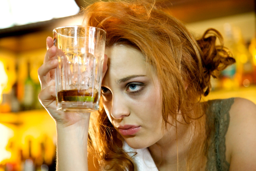

In [8]:
from fastdownload import download_url
dest = 'drunk.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "normal person photos":

Searching for 'normal person photos'


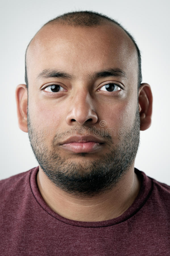

In [9]:
download_url(search_images('normal person photos', max_images=1)[0], 'normal.jpg', show_progress=False)
Image.open('normal.jpg').to_thumb(256,256)

In [10]:
searches = 'normal person photos','drunk person'
path = Path('drunk_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'normal person photos photo'
Searching for 'normal person photos sun photo'
Searching for 'normal person photos shade photo'
Searching for 'drunk person photo'
Searching for 'drunk person sun photo'
Searching for 'drunk person shade photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

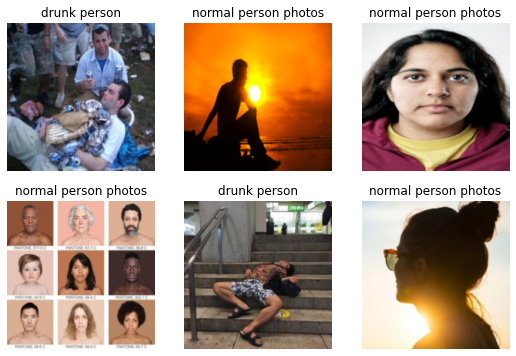

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.864865,0.491376,0.218750,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.550592,0.173645,0.093750,00:01
1,0.338150,0.085112,0.031250,00:01
2,0.237797,0.076048,0.000000,00:01


## Step 3: Use our model

In [14]:
is_bird,_,probs = learn.predict(PILImage.create('drunk.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a drunk person: {probs[0]:.4f}")

This is a: drunk person.
Probability it's a drunk person: 0.9983


# Step 4: Export our model

In [15]:
learn.export('model.pkl')

# Deploy
Link: https://huggingface.co/spaces/BrunoHenrique00/lesson2